In [1]:
# !pip install tensorflow==2.15.0

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request
import matplotlib as mpl
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('INFO')
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
# tf.config.experimental.set_visible_devices(devices=gpus[1], device_type='GPU')
# tf.config.experimental.set_memory_growth(device=gpus[1], enable=True)
import urllib
from dataclasses import dataclass
# import tensorflowjs as tfjs
# import tensorflow_decision_forests as tfdf
import json
from tqdm import tqdm
import seaborn as sns
import sys
np.random.seed(0)
urllib.request.urlretrieve('https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf', 'IBMPlexMono-Regular.ttf')
fe = font_manager.FontEntry(
    fname='IBMPlexMono-Regular.ttf',
    name='plexmono')
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update({'axes.facecolor':'#f5f4e9',
            'grid.color' : '#AAAAAA',
            'axes.edgecolor':'#333333',
            'figure.facecolor':'#FFFFFF',
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': fe.name,
            'figure.figsize': (3.5,3.5 / 1.2),
            'ytick.left': True,
            'xtick.bottom': True
           })

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
tf.__version__

'2.15.0'

In [5]:
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-positive.npz",
    "positive.npz",
)
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-negative.npz",
    "negative.npz",
)

with np.load("positive.npz") as r:
    pos_data = r[list(r.keys())[0]]
with np.load("negative.npz") as r:
    neg_data = r[list(r.keys())[0]]

In [6]:
def decoder(seq_vector):
  alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
  seq = []
  for i, index in enumerate(seq_vector.astype('int')):
    if index == 0:
      break
    seq.append(alphabet[index-1])
  seq = ''.join(seq)
  return seq

In [7]:
def counts_aa(vec):
    counts =  tf.histogram_fixed_width(vec, [0, 20], nbins=21)[1:]
    return counts /tf.reduce_sum(counts)


In [8]:
def build_fakes(n, data, max_length=200):
    result = []
    for _ in range(n):
        # sample this many subsequences
        avg_data_lengths = np.mean(np.count_nonzero(data, axis=1))
        k = np.clip(np.random.poisson(avg_data_lengths), 1, len(data) - 1)
        from scipy.stats import norm
        k = np.clip(np.random.poisson(1), 0, len(data) - 2) + 2
        idx = np.random.choice(range(len(data)), replace=False, size=k)
        seq = []
        lengths = []
        # cut-up k into one new sequence
        for i in range(k):
            if np.argmin(data[idx[i]]) > 1:
                l = np.ceil(2 * np.random.randint(1, np.argmin(data[idx[i]])) / k).astype(int)
                lengths.append(l)
                j = np.random.randint(0, np.argmin(data[idx[i]]) - lengths[i])
            else:
                lengths.append(1)
                j = 0
            s = data[idx[i]][j:j+lengths[i]]
            seq.append(s)
        seq.append([0] * (len(data[0]) - sum(lengths)))
        # check to make sure seq length >= 1 and is valid
        sample_seq = np.concatenate(seq)
        if np.argmin(np.concatenate(seq)) >= 1:
            result.append(sample_seq)
    return np.array(result)

sampled_vecs = build_fakes(pos_data.shape[0]*4, pos_data, max_length=100)
print(sampled_vecs.shape)
sampled_vecs = np.array(sampled_vecs)
sampled_vecs = np.unique(sampled_vecs, axis=0)
print(sampled_vecs.shape)

(7304, 190)
(7295, 190)


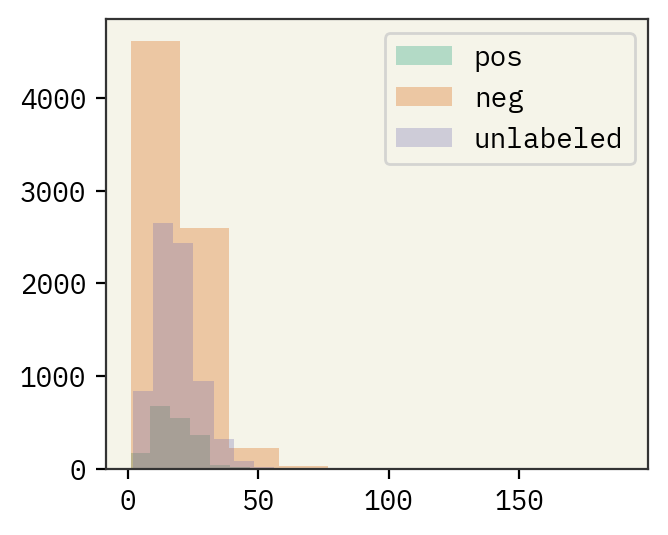

In [9]:
neg_data_lengths = np.count_nonzero(neg_data, axis=1)
unlabeled_data_lengths = np.count_nonzero(sampled_vecs, axis=1)
pos_data_lengths = np.count_nonzero(pos_data, axis=1)

plt.figure(dpi=200)
plt.hist(pos_data_lengths, label='pos', alpha=0.3)
plt.hist(neg_data_lengths, label='neg',alpha=0.3)
plt.hist(unlabeled_data_lengths, label='unlabeled', alpha=0.3)
plt.legend()

In [10]:
print(min(pos_data_lengths), min(neg_data_lengths), min(unlabeled_data_lengths))
print(max(pos_data_lengths), max(neg_data_lengths), max(unlabeled_data_lengths))

1 1 2
77 190 79


In [11]:
len(pos_data)

1826

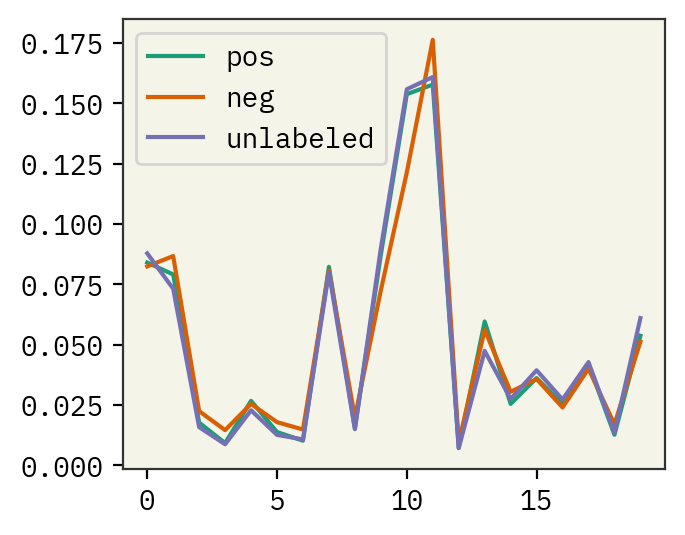

In [12]:
## AA frequencies
plt.figure(dpi=200)
plt.plot(counts_aa(pos_data), label='pos')
plt.plot(counts_aa(neg_data), label='neg')
plt.plot(counts_aa(sampled_vecs), label='unlabeled')
plt.legend()

In [13]:
def split_train_test_data(pos, neg, unlabeled, test_size_pos=0.1, val_size=0.1, unlabeled_size=0.2, seed=None):
    np.random.seed(seed)
    np.random.shuffle(pos)
    np.random.shuffle(neg)
    np.random.shuffle(unlabeled)
    from sklearn.model_selection import train_test_split
    X_test_negative = neg
    X_train_positive, X_test_positive, _, _ = train_test_split(pos, np.ones(pos.shape[0]),
                                                                                        test_size=test_size_pos, random_state=seed)
    X_train_positive, X_val_positive, _, _ = train_test_split(X_train_positive, np.ones(X_train_positive.shape[0]),
                                                                                    test_size=val_size, random_state=seed)
    X_unlabeled = unlabeled

    print(X_train_positive.shape, X_val_positive.shape, X_test_positive.shape, X_test_negative.shape,  X_unlabeled.shape)
    return X_train_positive, X_val_positive, X_test_positive, X_test_negative, X_unlabeled

seed = 0
X_train_positive, X_val_positive, X_test_positive, X_test_negative, X_unlabeled = split_train_test_data(pos_data, neg_data, sampled_vecs, seed=seed)

print('Positive data:', pos_data.shape[0])
print('Negative data:', neg_data.shape[0])
print('Unlabeled data:', len(X_unlabeled))

(1478, 190) (165, 190) (183, 190) (7490, 190) (7295, 190)
Positive data: 1826
Negative data: 7490
Unlabeled data: 7295


In [14]:
X_train = np.vstack([X_train_positive, X_unlabeled])
y_train = np.concatenate([np.ones(X_train_positive.shape[0]), np.zeros(X_unlabeled.shape[0])])
np.random.seed(seed)
train_shuffled_indices = np.random.permutation(len(X_train))
X_train = X_train[train_shuffled_indices]
y_train = y_train[train_shuffled_indices]

In [15]:
X_test = np.vstack([X_test_positive, X_test_negative])
y_test = np.concatenate([np.ones(X_test_positive.shape[0]), np.zeros(X_test_negative.shape[0])])

In [96]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float

config = Config(vocab_size=21, # include gap
                example_number=len(pos_data),
                batch_size=256,
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.2
               )

def counts_aa(vec):
    counts =  tf.histogram_fixed_width(vec, [0, 20], nbins=21)[1:]
    return counts/tf.reduce_sum(counts)

def build_model(L):
    inputs = tf.keras.Input(shape=(L,))
    input_f = tf.keras.Input(shape=(20,))
    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size,
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)

    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(x)
    x = tf.keras.layers.Concatenate()([x, input_f])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[inputs, input_f], outputs=yhat)
    return model



def train_model(X_train, y_train, batch_size=64, L=None):
    model = build_model(L)
    decay_epochs = 50
    decay_steps = len(X_train)  // 16 * decay_epochs
    lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
          config.lr, decay_steps, alpha=1e-3)
    opt = tf.optimizers.Adam(lr_decayed_fn)
    tf.keras.backend.clear_session()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='auc', patience=10, min_delta=1e-2, restore_best_weights=True)
    focal_loss  = tf.keras.losses.BinaryFocalCrossentropy(
                gamma=5, from_logits=False,  apply_class_balancing=True
                )
    model.compile(
            optimizer=opt,
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.AUC(from_logits=False), tf.keras.metrics.BinaryAccuracy(threshold=0.5)],
            )
    # print(f'\n\nModel l inputs : Negative:{plt.hist(y_train)[0][0]}, Positive:{plt.hist(y_train)[0][-1]}\n\n')
    history = model.fit(
        [X_train, np.array([counts_aa(xi) for xi in X_train])] , y_train,
#         validation_data=([X_test_L, np.array([counts_aa(xi) for xi in X_test_L])] , y_test_L),
        epochs=200,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=0,
    )
    return model

import queue
from threading import Thread, Lock
import traceback

def train_and_save_model(model_queue, X_train, y_train, batch_size, L, lock, thread_id):
    try:
        print(f"Starting training for model {thread_id}")
        model = train_model(X_train, y_train, batch_size, L)
        lock.acquire()
        model_queue.put(model)
        lock.release()
        print(f"Training completed for model {thread_id}")
    except Exception as e:
        print(f"An error occurred in model {thread_id}: {str(e)}")
        traceback.print_exc()

def sequential_train(num_models, X_train, y_train, L, shuffle_seed=0):
    np.random.seed(shuffle_seed)
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]
    models = []
    for _ in range(num_models):
        print(f"Starting training for model {_}")
        t = train_model(X_train, y_train, batch_size=config.batch_size, L=L)
        print(f"Training completed for model {_}")
        models.append(t)

    return models

def parallel_train(num_models, X_train, y_train, L):
    model_queue = queue.Queue()
    threads = []
    lock = Lock()

    for _ in range(num_models):
        t = Thread(target=train_and_save_model, args=(model_queue, X_train, y_train, config.batch_size, L, lock, _))
        t.start()
        threads.append(t)

    for t in threads:
        t.join()

    models = []
    while not model_queue.empty():
        models.append(model_queue.get())

    return models

class F1Score(tf.keras.metrics.Metric):
  def __init__(self, name='F1Score', **kwargs):
    super(F1Score, self).__init__(name=name, **kwargs)
    self.f1score = self.add_weight(name='F1Score', initializer='zeros')
    self.count = self.add_weight(name='F1ScoreCount', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    import keras.backend as K
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)

    true_positives = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
    true_positives = tf.cast(true_positives, self.dtype)
    count_true_positives = tf.reduce_sum(true_positives)

    possible_positives = tf.cast(y_true, self.dtype)
    count_possible_positives = tf.reduce_sum(possible_positives)

    predicted_positives = tf.cast(y_pred, self.dtype)
    count_predicted_positives = tf.reduce_sum(predicted_positives)

    precision = count_true_positives / (count_predicted_positives + K.epsilon())
    recall = count_true_positives / (count_possible_positives + K.epsilon())
    f1_cal = 2*(precision*recall)/(precision + recall + K.epsilon())

    self.count.assign_add(1)
    a = 1.0 / self.count
    b = 1.0 - a
    self.f1score.assign(a*f1_cal+b*self.f1score)

  def result(self):
    return self.f1score

Starting training for model 0


Model l inputs with spies: Negative:7295.0, Positive:1478.0


Epoch 1/200
35/35 - 17s - loss: 0.5175 - auc: 0.5218 - binary_accuracy: 0.8051 - 17s/epoch - 472ms/step
Epoch 2/200
35/35 - 1s - loss: 0.4636 - auc: 0.5662 - binary_accuracy: 0.8294 - 928ms/epoch - 27ms/step
Epoch 3/200
35/35 - 1s - loss: 0.4312 - auc: 0.6678 - binary_accuracy: 0.8314 - 914ms/epoch - 26ms/step
Epoch 4/200
35/35 - 1s - loss: 0.4096 - auc: 0.7254 - binary_accuracy: 0.8323 - 886ms/epoch - 25ms/step
Epoch 5/200
35/35 - 1s - loss: 0.3955 - auc: 0.7512 - binary_accuracy: 0.8355 - 898ms/epoch - 26ms/step
Epoch 6/200
35/35 - 1s - loss: 0.3826 - auc: 0.7742 - binary_accuracy: 0.8361 - 882ms/epoch - 25ms/step
Epoch 7/200
35/35 - 1s - loss: 0.3612 - auc: 0.8085 - binary_accuracy: 0.8461 - 858ms/epoch - 25ms/step
Epoch 8/200
35/35 - 1s - loss: 0.3561 - auc: 0.8139 - binary_accuracy: 0.8499 - 873ms/epoch - 25ms/step
Epoch 9/200
35/35 - 1s - loss: 0.3572 - auc: 0.8131 - binary_accuracy: 0.8

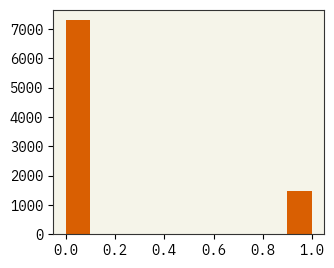

In [20]:
%%time
num_models = 5
L = X_train.shape[1]
# models = parallel_train(num_models, X_train, y_train, L)
models = sequential_train(num_models, X_train, y_train, L)

In [21]:
# # serialize model to JSON
# inference_model_json = inference_model.to_json()
# with open("../saved_models/model.json", "w") as json_file:
#     json_file.write(inference_model_json)
# # serialize weights to HDF5
# inference_model.save_weights("../saved_models/model.h5")
# # saving RNs
# np.save('../saved_models/model.npy', RN)

In [19]:
tf.config.set_visible_devices(gpus[0], 'GPU')

In [22]:
X_test = np.concatenate([X_test_positive, X_test_negative])
y_test = np.concatenate([np.ones(X_test_positive.shape[0]), np.zeros(X_test_negative.shape[0])])
# counts_test = np.array([counts_aa(xi) for xi in X_test])
# yhat_test =  models[0].predict([X_test, counts_test])

In [77]:
yhat_test =  models[1].evaluate([X_test, np.array([counts_aa(xi) for xi in X_test])], y_test)

240/240 [==============================] - 6s 8ms/step - loss: 0.9854 - auc: 0.7268 - binary_accuracy: 0.5999


In [78]:
yhat_test

[0.9854074120521545, 0.7267759442329407, 0.599895715713501]

In [87]:
def evaluate_models(models, X_test):
    yhats = []
    for m in models:
        yhat_test =  m.predict([X_test, np.array([counts_aa(xi) for xi in X_test])])
        yhats.append(yhat_test)
    mean_pred = np.mean(yhats, axis=0)
    std_pred = np.std(yhats, axis=0)
    return (mean_pred, std_pred)

def eval_BO(models, X_test, y_test):
    evals = []
    for m in models:
        loss, auc, acc  = m.evaluate([X_test, np.array([counts_aa(xi) for xi in X_test])], y_test)
        evals.append((auc, acc))
    mean_eval = np.mean(evals, axis=0)
    std_eval = np.std(evals, axis=0)
    return (mean_eval, std_eval)

# mu, sigma = evaluate_models(models, X_test)

In [86]:
eval_BO(models, X_test, y_test)

TypeError: eval_BO() got an unexpected keyword argument 'verbose'

In [31]:
ensemble_pred[0]

array([[0.01554203],
       [0.89326584],
       [0.3233506 ],
       ...,
       [0.72694063],
       [0.23141351],
       [0.01329567]], dtype=float32)

## BO Loop

In [25]:
from scipy.stats import norm

def expected_improvement(mean, std, best):
  '''
  EI implemented as available in this link
  https://ekamperi.github.io/machine%20learning/2021/06/11/acquisition-functions.html#expected-improvement-ei
  '''
  z = (mean - best) / std
  return (mean - best)*norm.cdf(z) + std*norm.pdf(z)

def upper_confidence_bound(mean, std, best):
  '''
  best not used for UCB. Just keeping it here to maintain the same signature for all acquisition functions
  '''
  _alpha = 1.0
  return mean + _alpha*std


In [42]:
list(zip(*ensemble_pred_U))

(array([0.00758104], dtype=float32), array([0.00407821], dtype=float32))

In [75]:
X_unlabeled.shape

(7295, 190)

In [ ]:
%%time

aqfxn = expected_improvement
best = 0
best_acc = 0
n_exps = 5
num_models = 5
from tqdm import tqdm
models = sequential_train(num_models, X_train, y_train, L)

for i in tqdm(range(1, n_exps+1)):
  print(f'\nIteration: {i}')
  N = i*len(X_unlabeled)//n_exps
  ensemble_pred_U = list(zip(*evaluate_models(models, X_unlabeled)))
  score_U = [aqfxn(1-y[0], y[1], best) for y in ensemble_pred_U]
  sorted_indices = sorted(range(len(score_U)), key=lambda x: score_U[x])[::-1]
  best = 1 - ensemble_pred_U[sorted_indices[0]][0]
  BO_negatives = X_unlabeled[sorted_indices][:N]
  new_X = np.concatenate([BO_negatives, X_train_positive])
  new_y = np.concatenate([np.zeros(len(BO_negatives)), np.ones(len(X_train_positive))])
  print(f'\nTraining with new BO dataset: negatives:{len(BO_negatives)}, positives: {len(X_train_positive)}')
  models = sequential_train(num_models, new_X, new_y, L)
  mean_auc, mean_acc = eval_BO(models, X_test, y_test)[0]
  print(f'\nIteration: {i} AUC:{mean_auc:.2f}, ACC:{mean_acc:.2f}')
  # new_dataset = pd.concat([pool_u[:N], pool_p[:N]])
  # new_dataset = new_dataset.sample(frac=1).reset_index(drop=True)

  # model = model.train(new_dataset['sequence'], new_dataset['class'])

Starting training for model 0


In [71]:
new_X = np.concatenate([X_unlabeled[:N], X_train_positive[:N]])
new_y = np.concatenate([np.ones(N), np.zeros(N)])

In [98]:
X_unlabeled[sorted_indices][:N]

array([[11, 11, 12, ...,  0,  0,  0],
       [10,  8,  1, ...,  0,  0,  0],
       [17, 16, 16, ...,  0,  0,  0],
       ...,
       [10, 12,  6, ...,  0,  0,  0],
       [14, 11, 15, ...,  0,  0,  0],
       [10, 16, 18, ...,  0,  0,  0]])

In [56]:
score_U = np.array([aqfxn(1-y[0], y[1], best) for y in ensemble_pred_U])

In [61]:
  sorted_indices = sorted(range(len(score_U)), key=lambda x: score_U[x])[::-1]
  score_U[sorted_indices]

array([[0.99601567],
       [0.99599761],
       [0.99598587],
       ...,
       [0.06268077],
       [0.05225123],
       [0.04783066]])

In [59]:
sorted(range(len(score_U)), key=lambda x: score_U[x])

[2552,
 3778,
 5441,
 6272,
 2006,
 229,
 4945,
 2770,
 1564,
 6734,
 6339,
 5867,
 3186,
 6804,
 4379,
 6392,
 1113,
 3109,
 3091,
 2287,
 4757,
 5365,
 3740,
 2737,
 6496,
 2482,
 1940,
 581,
 5175,
 6583,
 2221,
 3148,
 3879,
 6367,
 510,
 1,
 122,
 5235,
 5184,
 3311,
 2638,
 1228,
 1932,
 2715,
 6873,
 6552,
 3309,
 1789,
 745,
 1016,
 4653,
 4574,
 2452,
 4956,
 1799,
 3658,
 3183,
 1406,
 3595,
 5515,
 892,
 4437,
 4530,
 6475,
 1170,
 2551,
 3141,
 1429,
 7007,
 5376,
 1498,
 4666,
 3513,
 1111,
 5362,
 2367,
 6076,
 5061,
 7241,
 5238,
 4107,
 6189,
 4079,
 715,
 6861,
 7210,
 2938,
 4042,
 5047,
 2291,
 1873,
 2884,
 2466,
 4144,
 6769,
 4950,
 805,
 6853,
 2893,
 4348,
 259,
 5017,
 2377,
 1728,
 452,
 7086,
 3639,
 2873,
 1276,
 3868,
 4501,
 2856,
 5801,
 3173,
 7174,
 3959,
 1002,
 1825,
 4844,
 3913,
 5720,
 4682,
 1997,
 7068,
 2241,
 7190,
 1330,
 3972,
 3786,
 754,
 794,
 797,
 3670,
 3728,
 5080,
 4620,
 2933,
 3472,
 4213,
 5781,
 4113,
 3813,
 4564,
 6673,
 5881,
 

In [ ]:
plt.hist(yhat_test, label='predicted', alpha=0.5, bins=10)
plt.hist(y_test, label='true', alpha=0.5, bins=10)
plt.legend()

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

fpr, tpr, thresholds = roc_curve(y_test, yhat_test, drop_intermediate=False)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
best_accuracy_threshold = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
adjusted_y_hat_test = [1 if m>best_accuracy_threshold else 0 for m in yhat_test]
acc = accuracy_score(y_test, adjusted_y_hat_test, normalize=True)
print(f'Accuracy: {acc:.3f}')
f1 = f1_score(y_test, adjusted_y_hat_test, average='macro')
print(f'F1 Score: {f1:.3f}')
auc = roc_auc_score(y_test, yhat_test, average='macro')
print(f'AUC: {auc:.3f}')
plt.figure(dpi=200)
plt.hist(adjusted_y_hat_test, label='predicted', alpha=0.5, bins=10)
plt.hist(y_test, label='true', alpha=0.5, bins=10)
plt.legend()

In [ ]:
import ghostml
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# train_probs = model_2.predict([NP, np.array([counts_aa(xi) for xi in NP])])
thresholds = np.round(np.arange(0.1,0.95,0.005),2)
threshold1 = ghostml.optimize_threshold_from_predictions(y_test, yhat_test[:,0], thresholds, ThOpt_metrics = 'Kappa')
print(f'\nBest ghostml Threshold=%f, {threshold1}')
best_accuracy_threshold = threshold1
adjusted_y_hat_test = [1 if m>best_accuracy_threshold else 0 for m in yhat_test]
acc = accuracy_score(y_test, adjusted_y_hat_test, normalize=True)
print(f'Accuracy: {acc:.3f}')
f1 = f1_score(y_test, adjusted_y_hat_test, average='macro')
print(f'F1 Score: {f1:.3f}')
auc = roc_auc_score(y_test, yhat_test, average='macro')
print(f'AUC: {auc:.3f}')

plt.figure(dpi=200)
plt.hist(adjusted_y_hat_test, label='predicted', alpha=0.5, bins=10)
plt.hist(y_test, label='true', alpha=0.5, bins=10)
plt.legend()

#